In [1]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import chisqprob
import seaborn as sns

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.fill_bounds import *

sns.set_style('ticks')

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 /usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


In [2]:
directories = json.load(open('directories.json'))

off_sine_df_0 = pd.read_csv(directories['data'] + 'SMP_M1_RR1_IPL6_Sine0.csv', index_col = 0)
off_sine_df_0 = off_sine_df_0.groupby(['roi', 'frame']).mean().reset_index()
off_sine_df_0['t'] -= off_sine_df_0['t'].min()

sine_conditions_0 = pd.read_csv(directories['misc'] + 'sine_conditions_0.csv', header = None)
sine_conditions_0.columns = ["shape", "frequency", "contrast"]
sine_conditions_0['trial'] = np.arange(len(sine_conditions_0))
off_sine_df_0 = sine_conditions_0.merge(off_sine_df_0)

target_roi = 1

In [62]:
off_sine_df_0

,shape,frequency,contrast,trial,roi,frame,line,y,t,x_t
0,1.0,3.49,46.78,0,1.0,485.0,5.0,0.103886,0.002684,0.008270
1,1.0,3.49,46.78,0,1.0,486.0,5.0,-0.466781,0.034684,0.040270
2,1.0,3.49,46.78,0,1.0,487.0,5.0,-0.238112,0.066684,0.072270
3,1.0,3.49,46.78,0,1.0,488.0,5.0,1.191504,0.098684,0.104270
4,1.0,3.49,46.78,0,1.0,489.0,5.0,1.451501,0.130684,0.136270
5,1.0,3.49,46.78,0,1.0,490.0,5.0,1.407607,0.162684,0.168270
6,1.0,3.49,46.78,0,1.0,491.0,5.0,0.179436,0.194684,0.200270
7,1.0,3.49,46.78,0,1.0,492.0,5.0,-0.039469,0.226684,0.232270
8,1.0,3.49,46.78,0,1.0,493.0,5.0,-0.356828,0.258684,0.264270
9,1.0,3.49,46.78,0,1.0,494.0,5.0,-0.751901,0.290684,0.296270


In [3]:
off_sine_df = pd.read_csv(directories['data'] + 'SMP_M1_RR1_IPL6_Sine1.csv', index_col = 0)
off_sine_df = off_sine_df.groupby(['roi', 'frame']).mean().reset_index()
off_sine_df['t'] -= off_sine_df['t'].min()
off_sine_df['t'] += off_sine_df_0['t'].max()

sine_conditions_1 = pd.read_csv(directories['misc'] + 'sine_conditions_1.csv', header = None)
sine_conditions_1.columns = ["shape", "frequency", "contrast"]
sine_conditions_1['trial'] = np.arange(len(sine_conditions_1))
off_sine_df_1 = sine_conditions_1.merge(off_sine_df)

target_roi = 1

In [4]:
off_sine_df = pd.concat([off_sine_df_0, off_sine_df_1])
sine_conditions = pd.concat([sine_conditions_0, sine_conditions_1])

In [6]:
stimulation_start = off_sine_df['t'].min()

roi_df = off_sine_df.loc[off_sine_df['roi'] == target_roi, :]

x = roi_df['t']
y = roi_df['y']

stimulus = []
temporal_freq = 50

for itx, row in sine_conditions.iterrows():
    if row['shape'] != 0:
        stimulus.append(np.sin(np.linspace(0, 2 * np.pi, temporal_freq) * row['frequency']) * row['contrast'])
    else:
        stimulus.append(np.ones(temporal_freq) * np.nan)
        
sine_stimulus = np.hstack(stimulus)
sine_stimulus /= np.nanmax(sine_stimulus)
sine_tpnts = np.linspace(0, len(sine_conditions), len(sine_conditions) * temporal_freq) + stimulation_start

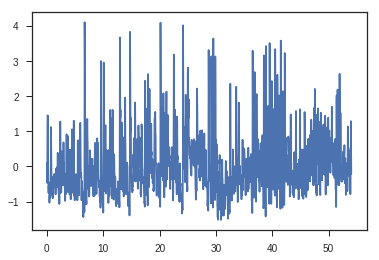

In [8]:
plt.plot(x, y)

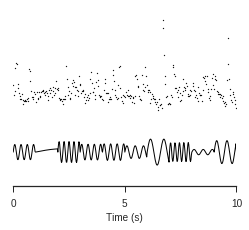

In [9]:
fig, ax = plt.subplots(1)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 1, color = 'k')

# ax.plot(x, y, linewidth = 0.5, color = 'k')
stimulus_delay = 0
ax.scatter(x - stimulus_delay, y, s = 1, color = 'k', marker = 'o')

start = stimulation_start
ax.set_xlim(start, start + 10)
ax.get_yaxis().set_visible(False)
plt.xticks([start, start + 5, start + 10])
ax.set_xticklabels([0, 5, 10])
sns.despine(left = True, ax = ax, offset = 10)
ax.set_xlabel('Time (s)', fontsize = 10);
plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(4, 3)

# plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mean_traces.png', **fig_p)

In [56]:
shape_bool = off_sine_df['shape'] == 1
roi_bool = off_sine_df['roi'] == target_roi
roi_df = off_sine_df.loc[shape_bool & roi_bool, :]

trial_duration = 1
roi_df['x_t'] = (roi_df['t'] - stimulus_delay) % trial_duration
roi_df['phase'] = (roi_df['x_t'] * 2 * np.pi * roi_df['frequency'])

x_cos = np.cos(roi_df['phase'].values)[:, None]
x_sin = np.sin(roi_df['phase'].values)[:, None]
x_frequency = roi_df['frequency'].values[:, None]
x_contrast = roi_df['contrast'].values[:, None]

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)
y = roi_df['y'][:, None]

 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

y = roi_df['y'][:, None]

k1 = GPy.kern.RBF(4, ARD = False, active_dims = [0, 1, 2, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 2])

m1 = GPy.models.SparseGPRegression(
        X,
        y,
        num_inducing = 500,
        kernel = k1
    )

%time m1.optimize_restarts(4, messages = True, max_iters = 25)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    04s21  03   2.076410e+03   2.645913e+05 
    16s05  14   1.836257e+03   5.564534e+02 
    31s52  27   1.828060e+03   2.575171e+01 
Runtime:     31s52
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 1828.0595144165902
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    06s20  06   2.040594e+03   7.621411e+03 
    21s19  19   1.963598e+03   5.526362e+02 
    30s27  27   1.957944e+03   1.141630e+01 
Runtime:     30s27
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 1957.9435170962465
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    10s20  09   2.071874e+03   8.786964e+02 
    30s98  27   1.942092e+03   2.798287e+02 
Runtime:     30s98
Optimization status: Maximum number of f evaluations reached

Optimization restart 3/4, f =

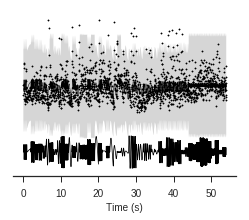

In [58]:
post_mu, post_sig = m1.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

x_t = roi_df['t']
ax.scatter(x_t, roi_df['y'], s = 2, color = 'k', marker = 'o')
ax.plot(x_t, post_mu, linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
# plt.xlim(56, 65)
# plt.xticks(np.arange(0, 12, 3) + 56)
# ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(4, 3)

In [13]:
n_tpnts = 256
freq_tpnts = np.linspace(0, 8, n_tpnts) + 10
x_new_frequency = ((np.pi * np.linspace(0, 8, n_tpnts) ** 2) % (2 * np.pi))[:, None]

i_freq = np.linspace(0, 8, 50)
i_cont = np.linspace(0, 100, 50)
n_freq = len(i_freq)
n_cont =  len(i_cont)
latent_uncertainty = np.zeros([n_freq, n_cont])

for itx, new_freq in enumerate(i_freq):
    for ity, new_cont in enumerate(i_cont):
            X_predict = np.concatenate([
                    np.cos(x_new_frequency),
                    np.sin(x_new_frequency),
                    new_freq * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None],
                    new_cont * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None] 
            ], axis = 1)

            latent_uncertainty[itx, ity] = np.sum(m1.predict(X_predict, include_likelihood = False)[1])

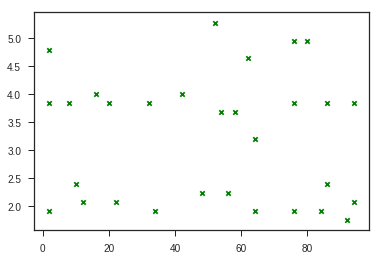

In [14]:
from skimage.feature import peak_local_max

n_peaks = 30

peaks = peak_local_max(latent_uncertainty,  min_distance = 1, exclude_border = True)
peaks_order = latent_uncertainty[peaks[:, 0], peaks[:, 1]].argsort()

peaks = peaks[peaks_order, :].astype(float)[:, ::-1]

peaks[:, 0] = (peaks[:, 0] + 1) /  n_cont * 100
peaks[:, 1] = (peaks[:, 1] + 1) / n_freq * 8

peaks = peaks[:n_peaks, :]

plt.scatter(peaks[:, 0], peaks[:, 1], color = 'g', s = 20, marker = 'x', clip_on = False)

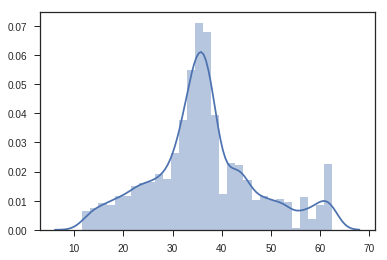

In [15]:
sns.distplot(latent_uncertainty.flatten())

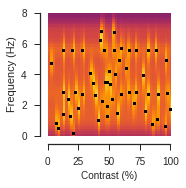

In [26]:
fig, ax = plt.subplots(1)

cax = ax.imshow(latent_uncertainty, origin = 'lower', cmap = 'inferno_r', extent = (0, 100, 0, 8), 
                aspect = 100 / 8, vmin = 0, vmax = 100)

ax.scatter(x_contrast, x_frequency, color = 'k', s = 5, marker = 'o', clip_on = False, label = 'Sampled')
# ax.scatter(peaks[:, 0], peaks[:, 1], color = 'k', s = 15, marker = 'x', clip_on = False, label = 'Proposed')

plt.xlim(0, 100)
plt.xticks(np.arange(0, 125, 25))
ax.set_xlabel('Contrast (%)', fontsize = 10)

plt.ylim(0, 8)
plt.yticks(np.arange(0, 10, 2), fontsize = 10)
ax.set_ylabel('Frequency (Hz)')

plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 8)

fig.set_size_inches(3.4, 3.4)

plt.tight_layout()

fig.set_size_inches(2.4, 2.4)

plt.savefig(directories['figs'] + 'active/' + 'Parameter Space 1.svg', dpi = 600)

In [17]:
np.savetxt(directories['data'] + 'latent_uncertainty_1.csv', latent_uncertainty.flatten(), 
           fmt = '%3.2f', delimiter = ',', newline = '\n\n')

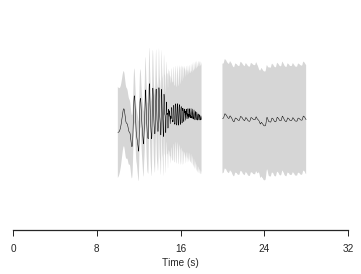

In [61]:
n_tpnts = 512

# Frequency Prediction

freq_tpnts = np.linspace(0, 8, n_tpnts)
x_new_frequency = (np.pi * freq_tpnts ** 2)[:, None]

X_predict = np.concatenate([
        np.cos(x_new_frequency),
        np.sin(x_new_frequency),
        np.linspace(0, 8, n_tpnts).flatten(order = 'f')[:, None],
        100 * np.ones([1, n_tpnts]).flatten(order = 'f')[:, None] 
], axis = 1)

freq_mu, freq_sig = m1.predict(X_predict, include_likelihood = False)

# Contrast Prediction

cont_tpnts = np.linspace(0, 8, n_tpnts) + 20
x_new_phase = (4 * cont_tpnts * np.pi)[:, None]

X_predict = np.concatenate([
        np.cos(x_new_phase),
        np.sin(x_new_phase),
        8 * np.ones([1, n_tpnts]).flatten(order = 'f')[:, None],
        np.linspace(0, 100, n_tpnts).flatten(order = 'f')[:, None] 
], axis = 1)

cont_mu, cont_sig = m1.predict(X_predict, include_likelihood = False)

fig, ax = plt.subplots(1)

ax.plot(cont_tpnts, cont_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(cont_mu, cont_sig, n_sigma = 3)
ax.fill_between(cont_tpnts, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.plot(freq_tpnts + 10, freq_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(freq_mu, freq_sig, n_sigma = 3)
ax.fill_between(freq_tpnts  + 10, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
ax.set_ylim(-3, 3)
sns.despine(ax = ax, left = True)

# fig.set_size_inches(2.8, 1.5)

# plt.savefig(directories['figs'] + 'active/' + 'sine_itr1.svg', dpi = 300)